In [1]:
import pandas as pd
import pickle

from collections import defaultdict
import string

import torch
from torch import nn
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from transformers import DistilBertConfig, DistilBertTokenizer
from transformers import RobertaConfig
from datasets import Dataset
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

from IPython.display import display, HTML

from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

2025-07-02 20:25:24.193493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751487924.393795      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751487924.447614      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [3]:
checkpoint = "ConditionalNLI/Exp8_llama3.2"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, device_map="auto", output_attentions=True)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

## Running on Dataset

In [6]:
from datasets import load_dataset, concatenate_datasets
import json
import ast

In [7]:
test_df4 = pd.read_excel('/kaggle/input/confer-extension/Part5_Dataset/Part5_Type4.xlsx')
test_df4

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related
1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related
2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related
3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related
4,"If Noah is a pastry chef, he'll use his pastry...",Noah has a pastry bag.,E,possessive,his pastry bag,decorate cakes and pastries,related
...,...,...,...,...,...,...,...
292,"If Christina is a makeup artist, she'll grab h...",Christina has a makeup sponge.,E,possessive,her makeup sponge,rides a scooter,unrelated
293,"If Rahim is a clergyman, he'll bring his holy ...",Rahim has a holy book.,E,possessive,his holy book,gardens roses,unrelated
294,"If James is a police officer, he'll pick his g...",James has a gun.,E,possessive,his gun,drinks tea,unrelated
295,"If Maya is a piano teacher, she'll pack her me...",Maya has a metronome.,E,possessive,her metronome,knits hats,unrelated


In [8]:
test_df5p = pd.read_excel('/kaggle/input/confer-extension/Part5_Dataset/Part5_Type5P.xlsx')
test_df5p

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,possessive,her colleague,the university,related
1,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,possessive,her best friend,post exam celebratory dinner,related
2,"If Scarlett finishes her chores early, her hus...",Scarlett has a husband.,E,possessive,her husband,lunch,related
3,"If Chloe finishes his project early, his colle...",Chloe has colleagues.,E,possessive,his colleagues,drinks,related
4,"If Charlotte passes her math test, her parents...",Charlotte has parents.,E,possessive,her parents,a calculator,related
...,...,...,...,...,...,...,...
795,"If Dorothy bike breaks down, her brother will ...",Dorothy has a brother.,E,possessive,her brother,water her garden at home,unrelated
796,"If Susan finishes her assignment early, her co...",Susan has a colleague.,E,possessive,his colleague,dust his shelves at the dorm,unrelated
797,"If Margaret finishes work early, her wife will...",Margaret has a wife.,E,possessive,his wife,plant a tree for him,unrelated
798,"If Betty misses the train, her brother will ma...",Betty has a brother.,E,possessive,her brother,make her origami to class,unrelated


In [9]:
test_df5a = pd.read_excel('/kaggle/input/confer-extension/Part5_Dataset/Part5_Type5A.xlsx')
test_df5a

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,"If Jessica attends a movie festival, she'll ne...",Jessica has watched a movie by Nolan before.,E,again,attends a movie festival,watch a movie by Nolan again,related
1,"If Emily finishes a mystery novel, she'll neve...",Emily has read a book by Dan Brown before.,E,again,finishes a mystery novel,read a book by Dan Brown again,related
2,"If Scarlett bakes a Swedish pastry, she'll nev...",Scarlett has eaten a traditional Swedish dish ...,E,again,bakes a Swedish pastry,eat a traditional Swedish dish again,related
3,"If Chloe attends a pop concert, she'll never s...",Chloe has sung a pop song before.,E,again,attends a pop concert,sing a pop song again,related
4,"If Charlotte attends a pop music festival, she...",Charlotte has listened to a pop song before.,E,again,attends a pop music festival,listen to a pop song again,related
...,...,...,...,...,...,...,...
795,"If Dorothy's car breaks down, she'll never obt...",Dorothy has obtained a job position before.,E,again,breaks down,obtain a job position again,unrelated
796,"If Susan finishes her work early, she'll never...",Susan has conveyed a confidential message before.,E,again,finishes her work early,convey a confidential message again,unrelated
797,"If Margaret finishes work early, she'll never ...",Margaret has managed to keep a secret before.,E,again,finishes work early,manage to keep a secret again,unrelated
798,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,again,misses the bus,cherish a moment in peace again,unrelated


In [10]:
test_df = pd.concat([test_df4,test_df5a,test_df5p])
test_df

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related
1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related
2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related
3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related
4,"If Noah is a pastry chef, he'll use his pastry...",Noah has a pastry bag.,E,possessive,his pastry bag,decorate cakes and pastries,related
...,...,...,...,...,...,...,...
795,"If Dorothy bike breaks down, her brother will ...",Dorothy has a brother.,E,possessive,her brother,water her garden at home,unrelated
796,"If Susan finishes her assignment early, her co...",Susan has a colleague.,E,possessive,his colleague,dust his shelves at the dorm,unrelated
797,"If Margaret finishes work early, her wife will...",Margaret has a wife.,E,possessive,his wife,plant a tree for him,unrelated
798,"If Betty misses the train, her brother will ma...",Betty has a brother.,E,possessive,her brother,make her origami to class,unrelated


In [11]:
test_df.to_csv('part5_all.csv')

In [12]:
sample_test_df = test_df4.iloc[:4].reset_index()
sample_test_df 

,index,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related
1,1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related
2,2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related
3,3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related


In [13]:
sample_test_df = test_df4[test_df4['premise'].str.contains('If Liam is an aerospace')]
sample_test_df

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related
99,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,cool off on a hot summer day,somewhat_related
198,"If Liam is an aerospace engineer, he'll grab h...",Liam has a wind tunnel.,E,possessive,his wind tunnel,feeds the cat,unrelated


In [14]:
test_df = sample_test_df

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, device_map="auto", output_attentions=True)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.config.pad_token_id = model.config.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.problem_type = "single_label_classification"

In [17]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['premise', 'hypothesis', 'gold_label', 'trigger', 'key_phrase1', 'key_phrase2', 'type', '__index_level_0__'],
    num_rows: 3
})

In [18]:
columns_to_keep = ['index', 'premise', 'hypothesis']
test_ds = test_ds.remove_columns([col for col in test_ds.column_names if col not in columns_to_keep])
test_ds

Dataset({
    features: ['premise', 'hypothesis'],
    num_rows: 3
})

In [19]:
def tokenize_function(example):
    return tokenizer(example["premise"], example["hypothesis"], truncation=True, max_length=256, padding='max_length')

In [20]:
def predict_with_probs(test_df):

    test_ds = Dataset.from_pandas(test_df)
    columns_to_keep = ['index', 'premise', 'hypothesis']
    test_ds = test_ds.remove_columns([col for col in test_ds.column_names if col not in columns_to_keep])
    tokenized_test_ds = test_ds.map(tokenize_function, batched=True)
    tokenized_test_ds.set_format("torch")
    tokenized_test_ds = tokenized_test_ds.remove_columns(["premise", "hypothesis"])
    
    # Predicting Labels on Dataset
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=256, return_tensors="pt")
    dataloader = DataLoader(tokenized_test_ds, batch_size=32, collate_fn=data_collator)
    
    model.eval()
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            probabilities.extend(probs.cpu().tolist())
    
    test_df['predicted_label'] = predictions
    test_df['prediction_probs'] = probabilities
    return test_df
    

In [21]:
test_df4.to_csv('part5_type4_deberta_results_with_probs.csv')
test_df5p.to_csv('part5_type5p_deberta_results_with_probs.csv')
test_df5a.to_csv('part5_type5a_deberta_results_with_probs.csv')

In [22]:
import string

def is_content_token(token):
    # Remove special tokens 
    return token not in tokenizer.all_special_tokens

In [23]:
def compute_attention(row):

    premise = row['premise']
    hypothesis = row['hypothesis']
    inputs = tokenizer(premise, hypothesis, return_tensors='pt')
    inputs.pop('token_type_ids', None)  # for llama 

    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()} 
    
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions

    return inputs, attentions

In [24]:
def cls_token_attention(row):
    # Aggregating Attention scores 
    attn_tensor = torch.stack(outputs.attentions)  # shape: (num_layers, batch, num_heads, seq_len, seq_len)
    cls_index = 0  # RoBERTa’s <s> token is at index 0
    cls_attention = attn_tensor[:, :, :, cls_index, :]  # shape: (num_layers, batch, num_heads, seq_len)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attention_values = cls_attention.mean(dim=(0,1,2)).squeeze().tolist()
    
    # Filter
    filtered_tokens = []
    filtered_attention = []
    
    for token, attn in zip(tokens, attention_values):
        if is_content_token(token):
            filtered_tokens.append(token)
            filtered_attention.append(attn)

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(filtered_tokens)), filtered_attention)
    plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=90)
    plt.title("Attention from <s> Token (Filtered to Words Only)")
    plt.tight_layout()
    plt.show()

## Average Attention

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def average_attention(row): 

    inputs, attention = compute_attention(row)
    
    attn_tensor = torch.stack(attention)  # Shape: (num_layers, batch, num_heads, seq_len, seq_len)
    avg_attn = attn_tensor.mean(dim=(0, 1, 2))  # Shape: (seq_len, seq_len)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    avg_attn = avg_attn.detach().cpu().numpy()    

    return pd.Series([avg_attn, tokens])

In [39]:
sample_test_df

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero..."
99,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,cool off on a hot summer day,somewhat_related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero..."
198,"If Liam is an aerospace engineer, he'll grab h...",Liam has a wind tunnel.,E,possessive,his wind tunnel,feeds the cat,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero..."


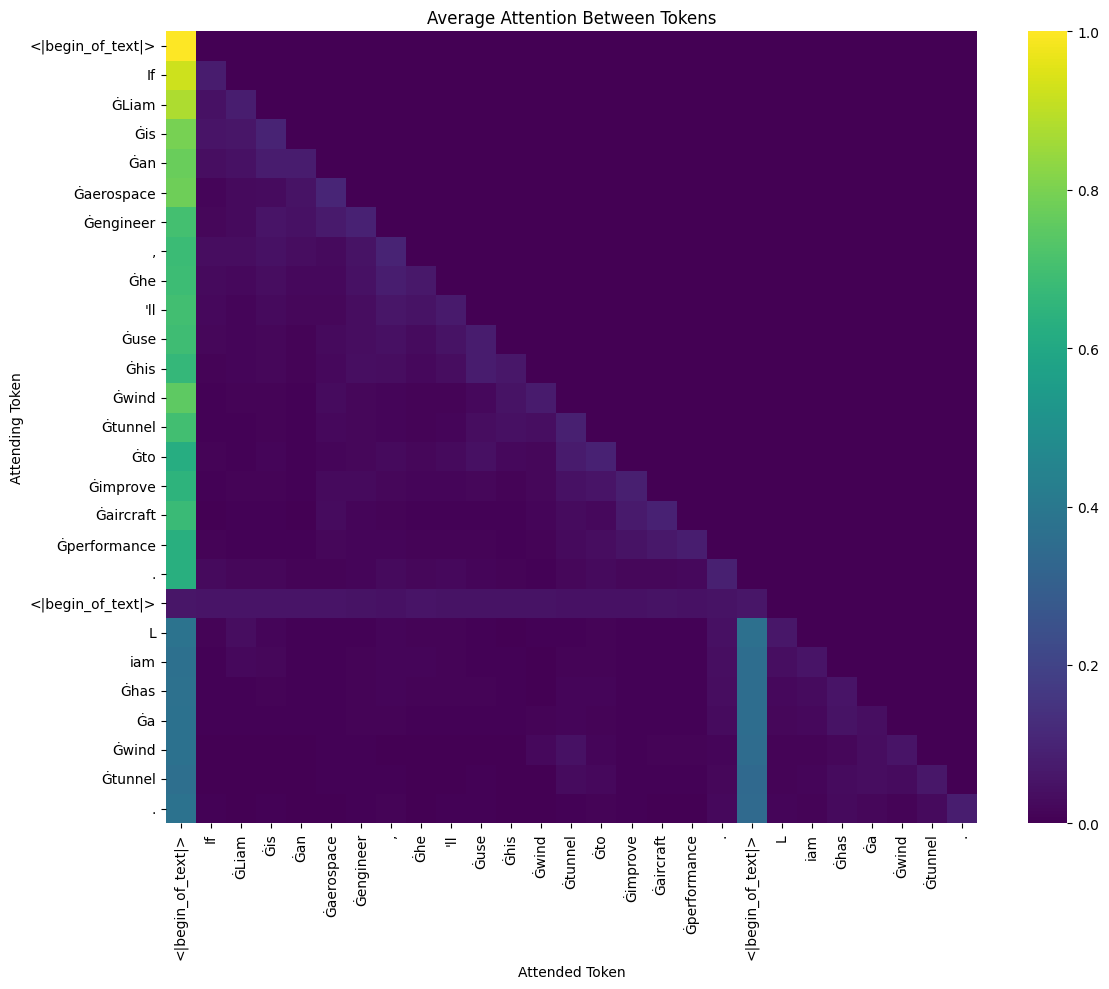

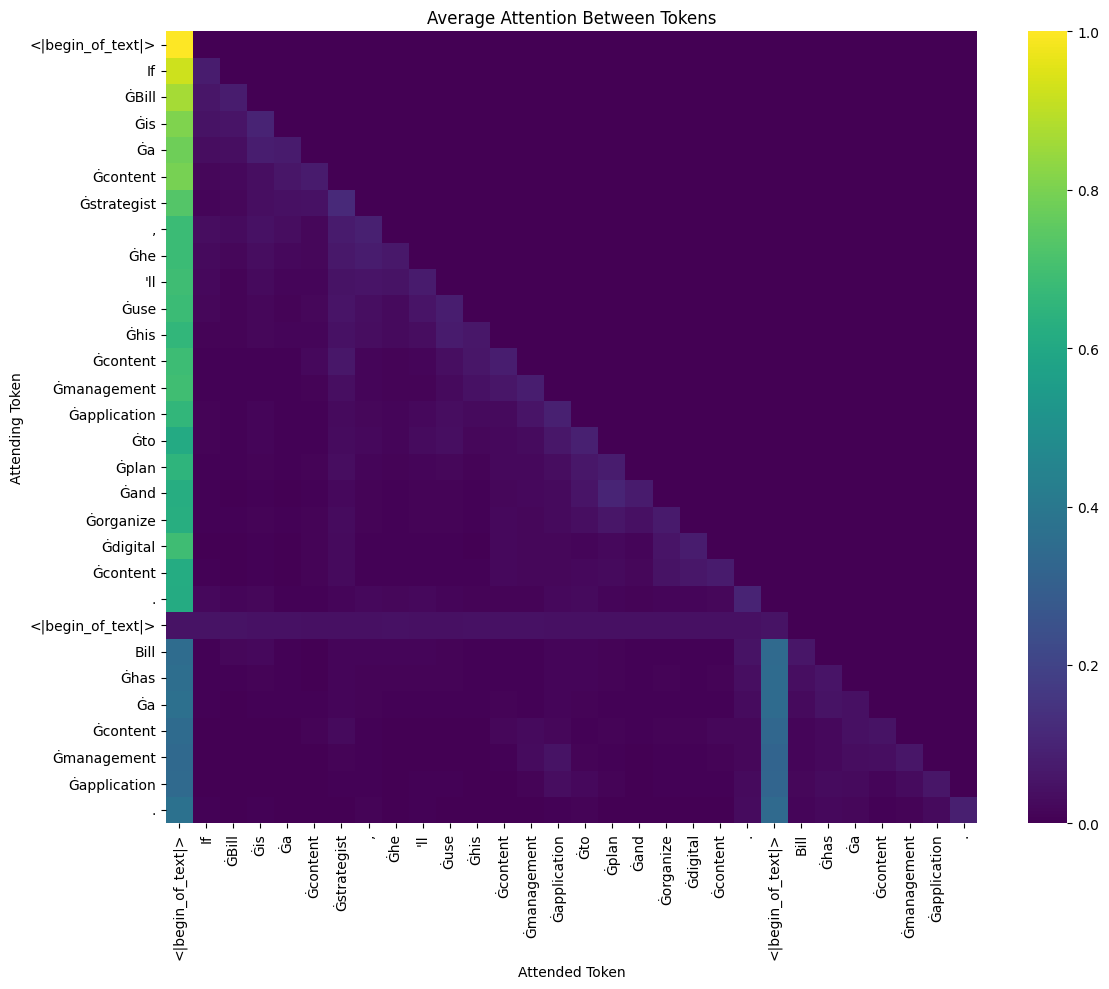

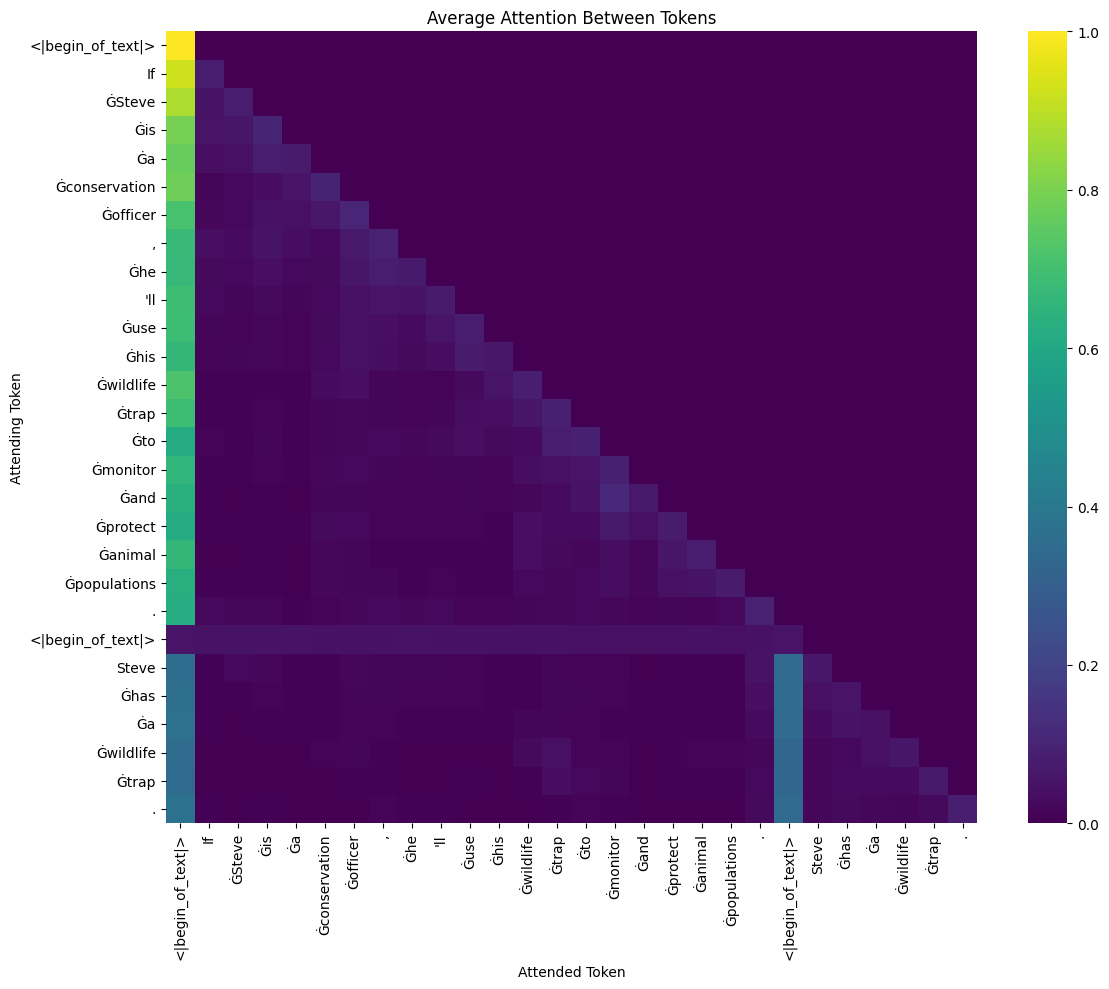

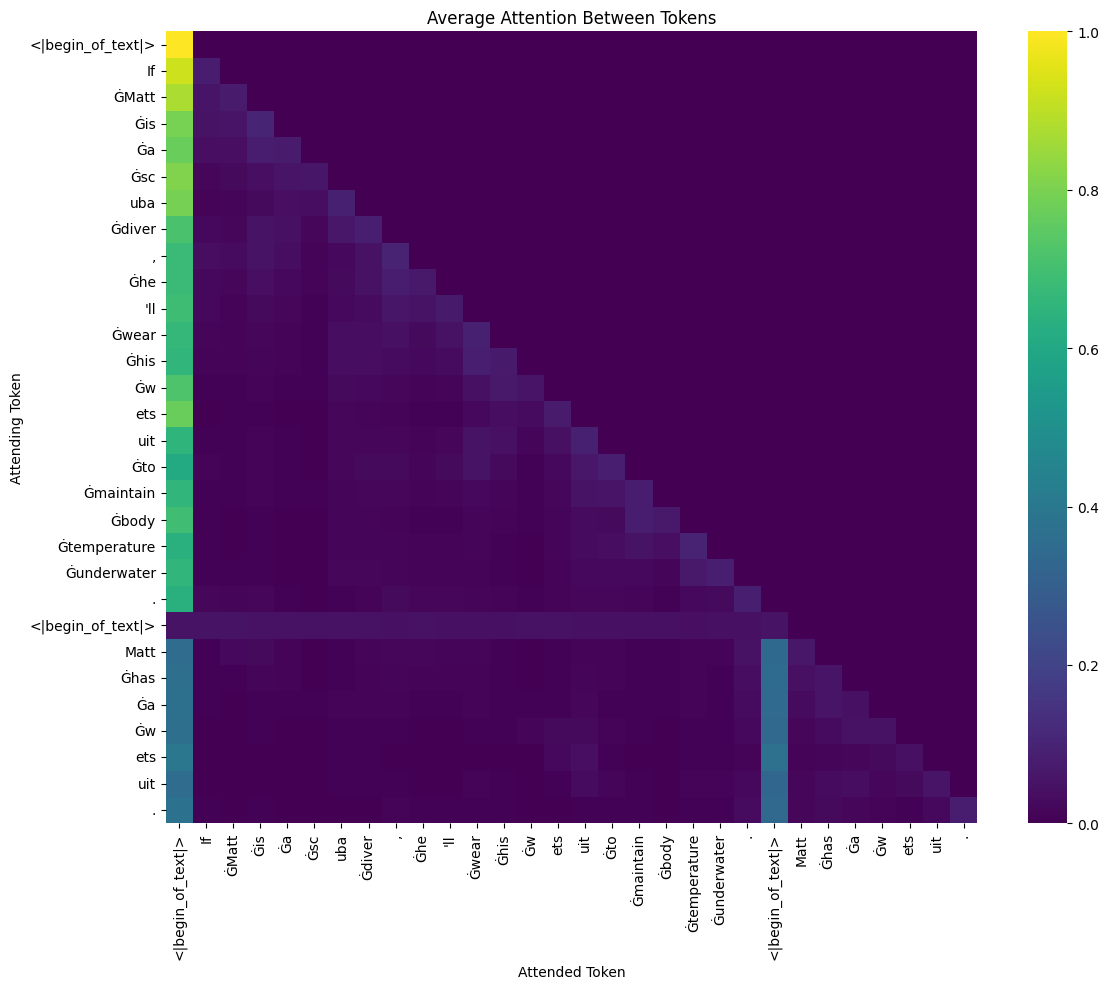

,index,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention
0,0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Liam': ..."
1,1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBill, Ġis, Ġa, Ġconte...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Bill': ..."
2,2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSteve, Ġis, Ġa, Ġcons...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Steve':..."
3,3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMatt, Ġis, Ġa, Ġsc, u...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Matt': ..."


In [44]:
sample_test_df[['attention','tokens']] = sample_test_df.apply(average_attention,axis=1)
sample_test_df

In [34]:
def compute_attention_metrics(row):

    avg_attention = row['attention']
    tokens =  row['tokens']
    attention_df = pd.DataFrame(avg_attention,index=tokens,columns=tokens)

    # clean attention matrix 
    partial_words = [tok for i,tok in enumerate(attention_df.index) if not tok.startswith('Ġ') 
                and tok not in string.punctuation
                and tok not in tokenizer.all_special_tokens
                and attention_df.index[i-1] not in tokenizer.all_special_tokens]

    # if it's a partial word, add its row to the previous row (merging tokens)
    for i in range(len(attention_df)-1,0,-1):
        current_token = attention_df.index[i]
        prev_token = attention_df.index[i-1]
        if is_partial_word(current_token,prev_token):
            attention_df.iloc[i-1] += attention_df.iloc[i] # first row gets total value
            attention_df.iloc[i] = 0 # set second row to 0
            merged_token = attention_df.index.values[i-1] + attention_df.index.values[i]
            attention_df.index.values[i-1] = merged_token

    attention_df.index = [token[1:] if token.startswith('Ġ') else token for token in attention_df.index]

    # repeat for columns
    for i in range(attention_df.shape[1]-1,0,-1):
        current_token = attention_df.columns[i]
        prev_token = attention_df.columns[i-1]
        if is_partial_word(current_token,prev_token):
            attention_df.iloc[:, i-1] += attention_df.iloc[:, i]
            attention_df.iloc[:, i] = 0
            merged_token = attention_df.columns.values[i - 1] + current_token
            attention_df.columns.values[i-1] = merged_token

    attention_df.columns = [token[1:] if token.startswith('Ġ') else token for token in attention_df.columns ]

    # dropping rows and columns that aren't words
    attention_df = attention_df[attention_df.index.to_series().apply(is_content_token)]
    drop_cols = [col for col in attention_df.columns if not is_content_token(col)]
    attention_df = attention_df.drop(columns=drop_cols)
    # print(attention_df)

    # compute overall average attention
    avg_attention = attention_df.mean().mean()

    # compute average attention from key_phrase1 to key_phrase2 
    key_phrase1 = row['key_phrase1']
    key_phrase2 = row['key_phrase2']
    
    key_phrase1_words = key_phrase1.split()
    key_phrase2_words = key_phrase2.split()

    start_key_phrase1 = key_phrase1_words[0]
    end_key_phrase1 = key_phrase1_words[-1]
    start_key_phrase2 = key_phrase2_words[0]
    end_key_phrase2 = key_phrase2_words[-1]
    phrase_thresholds = [start_key_phrase1, end_key_phrase1, start_key_phrase2, end_key_phrase2]
    indices = {}
    try:
        indices['start_key_phrase1'] = list(attention_df.index).index(start_key_phrase1)
    except: 
        if 'his' in attention_df.index: 
            start_key_phrase1 = 'his'
        elif 'her' in attention_df.index: 
            start_key_phrase1 = 'her'
        elif 'their' in attention_df.index: 
            start_key_phrase1 = 'their'
        else:
            return pd.Series([avg_attention,None])

    try:
        indices['start_key_phrase2'] = list(attention_df.index).index(start_key_phrase2)
    except:
        if 'to' in attention_df.index: 
            indices['start_key_phrase2'] = list(attention_df.index).index('to') + 1
        else:
            return pd.Series([avg_attention,None])

    # searching for end index starts after start index
    try:
        indices['end_key_phrase1'] = indices['start_key_phrase1'] + list(attention_df.index)[indices['start_key_phrase1']:].index(end_key_phrase1) + 1
    except:
        if 'to' in attention_df.index: 
            indices['end_key_phrase1'] = list(attention_df.index).index('to')
        else:
            return pd.Series([avg_attention,None])

    try:
        indices['end_key_phrase2'] = indices['start_key_phrase2'] + list(attention_df.index)[indices['start_key_phrase2']:].index(end_key_phrase2) + 1
    except:
        if '.' in attention_df.index: 
            indices['end_key_phrase2'] = list(attention_df.index).index('.')
        else:
            return pd.Series([avg_attention,None])
    
    # print(indices)
    
    key_phrase_attention = attention_df.iloc[indices['start_key_phrase1']:indices['end_key_phrase1'],indices['start_key_phrase1']:indices['end_key_phrase1']]
    avg_key_phrase_attention = key_phrase_attention.mean().mean()
    # print(avg_key_phrase_attention)
    
    return pd.Series([avg_attention,avg_key_phrase_attention])

In [42]:
sample_test_df[['attention','tokens']] = sample_test_df.apply(average_attention,axis=1)

In [ ]:
sample_test_df[['avg_attention','avg_key_phrase_attention']] = sample_test_df.apply(compute_attention_metrics, axis=1)
sample_test_df

In [55]:
test_df4[['attention','tokens']] = test_df4.apply(average_attention,axis=1)
test_df4[['avg_attention','avg_key_phrase_attention']] = test_df4.apply(compute_attention_metrics, axis=1)
test_df4

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,avg_attention,avg_key_phrase_attention
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠLiam, Ġis, Ġan, Ġaerospace, Ġengi...",0.014497,0.042422
1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠBill, Ġis, Ġa, Ġcontent, Ġstrateg...",0.014671,0.044243
2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠSteve, Ġis, Ġa, Ġconservation, Ġo...",0.015521,0.048162
3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠMatt, Ġis, Ġa, Ġsc, uba, Ġdiver, ...",0.013787,0.164486
4,"If Noah is a pastry chef, he'll use his pastry...",Noah has a pastry bag.,E,possessive,his pastry bag,decorate cakes and pastries,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠNoah, Ġis, Ġa, Ġpastry, Ġchef, ,,...",0.014348,0.047822
...,...,...,...,...,...,...,...,...,...,...,...
292,"If Christina is a makeup artist, she'll grab h...",Christina has a makeup sponge.,E,possessive,her makeup sponge,rides a scooter,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠChristina, Ġis, Ġa, Ġmakeup, Ġart...",0.015124,0.046641
293,"If Rahim is a clergyman, he'll bring his holy ...",Rahim has a holy book.,E,possessive,his holy book,gardens roses,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠRah, im, Ġis, Ġa, Ġclergy, man, ,...",0.016876,0.051400
294,"If James is a police officer, he'll pick his g...",James has a gun.,E,possessive,his gun,drinks tea,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠJames, Ġis, Ġa, Ġpolice, Ġofficer...",0.016890,0.054032
295,"If Maya is a piano teacher, she'll pack her me...",Maya has a metronome.,E,possessive,her metronome,knits hats,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠMaya, Ġis, Ġa, Ġpiano, Ġteacher, ...",0.014387,0.176952


In [56]:
test_df4['avg_attention'].mean()

0.015374842868108139

In [57]:
test_df4['avg_key_phrase_attention'].mean()

0.06369932055020251

In [58]:
test_df4.groupby('type')['avg_key_phrase_attention'].mean()

type
related             0.064116
somewhat_related    0.063505
unrelated           0.063481
Name: avg_key_phrase_attention, dtype: float64

In [59]:
test_df4.to_csv('llama_part5_type4.csv')

## Type 5P

In [60]:
test_df5p[['attention','tokens']] = test_df5p.apply(average_attention,axis=1)
test_df5p[['avg_attention','avg_key_phrase_attention']] = test_df5p.apply(compute_attention_metrics, axis=1)
test_df5p

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,avg_attention,avg_key_phrase_attention
0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,possessive,her colleague,the university,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠJessica, Ġattends, Ġthe, Ġconfere...",0.018468,0.059121
1,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,possessive,her best friend,post exam celebratory dinner,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠEmily, Ġpasses, Ġher, Ġdriving, Ġ...",0.014198,0.032675
2,"If Scarlett finishes her chores early, her hus...",Scarlett has a husband.,E,possessive,her husband,lunch,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠScarlett, Ġfinishes, Ġher, Ġchore...",0.017593,0.036010
3,"If Chloe finishes his project early, his colle...",Chloe has colleagues.,E,possessive,his colleagues,drinks,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠChloe, Ġfinishes, Ġhis, Ġproject,...",0.018682,0.040131
4,"If Charlotte passes her math test, her parents...",Charlotte has parents.,E,possessive,her parents,a calculator,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠCharlotte, Ġpasses, Ġher, Ġmath, ...",0.017727,0.039953
...,...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy bike breaks down, her brother will ...",Dorothy has a brother.,E,possessive,her brother,water her garden at home,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠDorothy, Ġbike, Ġbreaks, Ġdown, ,...",0.016200,0.051075
796,"If Susan finishes her assignment early, her co...",Susan has a colleague.,E,possessive,his colleague,dust his shelves at the dorm,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠSusan, Ġfinishes, Ġher, Ġassignme...",0.018891,0.023365
797,"If Margaret finishes work early, her wife will...",Margaret has a wife.,E,possessive,his wife,plant a tree for him,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠMargaret, Ġfinishes, Ġwork, Ġearl...",0.016396,NaN
798,"If Betty misses the train, her brother will ma...",Betty has a brother.,E,possessive,her brother,make her origami to class,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠBetty, Ġmisses, Ġthe, Ġtrain, ,, ...",0.017157,0.060837


In [61]:
test_df5p['avg_key_phrase_attention'].isna().sum()

7

In [62]:
test_df5p['avg_attention'].mean()

0.0166887558309827

In [63]:
test_df5p['avg_key_phrase_attention'].mean()

0.05019930180768197

In [64]:
test_df5p.groupby('type')['avg_key_phrase_attention'].mean()

type
related      0.050226
unrelated    0.050172
Name: avg_key_phrase_attention, dtype: float64

In [65]:
test_df5p.to_csv('llama_part5_type5p.csv')

## Type 5A

In [66]:
test_df5a

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type
0,"If Jessica attends a movie festival, she'll ne...",Jessica has watched a movie by Nolan before.,E,again,attends a movie festival,watch a movie by Nolan again,related
1,"If Emily finishes a mystery novel, she'll neve...",Emily has read a book by Dan Brown before.,E,again,finishes a mystery novel,read a book by Dan Brown again,related
2,"If Scarlett bakes a Swedish pastry, she'll nev...",Scarlett has eaten a traditional Swedish dish ...,E,again,bakes a Swedish pastry,eat a traditional Swedish dish again,related
3,"If Chloe attends a pop concert, she'll never s...",Chloe has sung a pop song before.,E,again,attends a pop concert,sing a pop song again,related
4,"If Charlotte attends a pop music festival, she...",Charlotte has listened to a pop song before.,E,again,attends a pop music festival,listen to a pop song again,related
...,...,...,...,...,...,...,...
795,"If Dorothy's car breaks down, she'll never obt...",Dorothy has obtained a job position before.,E,again,breaks down,obtain a job position again,unrelated
796,"If Susan finishes her work early, she'll never...",Susan has conveyed a confidential message before.,E,again,finishes her work early,convey a confidential message again,unrelated
797,"If Margaret finishes work early, she'll never ...",Margaret has managed to keep a secret before.,E,again,finishes work early,manage to keep a secret again,unrelated
798,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,again,misses the bus,cherish a moment in peace again,unrelated


In [ ]:
test_df5a[test_df5a['key_phrase2'].isna()]

In [67]:
test_df5a[['attention','tokens']] = test_df5a.apply(average_attention,axis=1)
test_df5a[['avg_attention','avg_key_phrase_attention']] = test_df5a.apply(compute_attention_metrics, axis=1)
test_df5a

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,avg_attention,avg_key_phrase_attention
0,"If Jessica attends a movie festival, she'll ne...",Jessica has watched a movie by Nolan before.,E,again,attends a movie festival,watch a movie by Nolan again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠJessica, Ġattends, Ġa, Ġmovie, Ġf...",0.014913,0.048115
1,"If Emily finishes a mystery novel, she'll neve...",Emily has read a book by Dan Brown before.,E,again,finishes a mystery novel,read a book by Dan Brown again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠEmily, Ġfinishes, Ġa, Ġmystery, Ġ...",0.014379,0.052865
2,"If Scarlett bakes a Swedish pastry, she'll nev...",Scarlett has eaten a traditional Swedish dish ...,E,again,bakes a Swedish pastry,eat a traditional Swedish dish again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠScarlett, Ġb, akes, Ġa, ĠSwedish,...",0.014663,0.054967
3,"If Chloe attends a pop concert, she'll never s...",Chloe has sung a pop song before.,E,again,attends a pop concert,sing a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠChloe, Ġattends, Ġa, Ġpop, Ġconce...",0.015813,0.047297
4,"If Charlotte attends a pop music festival, she...",Charlotte has listened to a pop song before.,E,again,attends a pop music festival,listen to a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠCharlotte, Ġattends, Ġa, Ġpop, Ġm...",0.013420,0.043727
...,...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy's car breaks down, she'll never obt...",Dorothy has obtained a job position before.,E,again,breaks down,obtain a job position again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠDorothy, 's, Ġcar, Ġbreaks, Ġdown...",0.015196,0.059619
796,"If Susan finishes her work early, she'll never...",Susan has conveyed a confidential message before.,E,again,finishes her work early,convey a confidential message again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠSusan, Ġfinishes, Ġher, Ġwork, Ġe...",0.017180,0.048357
797,"If Margaret finishes work early, she'll never ...",Margaret has managed to keep a secret before.,E,again,finishes work early,manage to keep a secret again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠMargaret, Ġfinishes, Ġwork, Ġearl...",0.014596,0.058385
798,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,again,misses the bus,cherish a moment in peace again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[CLS], If, ĠBetty, Ġmisses, Ġthe, Ġbus, ,, Ġs...",0.016240,0.069530


In [68]:
test_df5a['avg_key_phrase_attention'].isna().sum()

2

In [69]:
test_df5a['avg_attention'].mean()

0.014392120856791734

In [70]:
test_df5a['avg_key_phrase_attention'].mean()

0.05183753357000444

In [71]:
test_df5a.groupby('type')['avg_attention'].mean()

type
related      0.014178
unrelated    0.014606
Name: avg_attention, dtype: float64

In [72]:
test_df5a.groupby('type')['avg_key_phrase_attention'].mean()

type
related      0.046799
unrelated    0.056876
Name: avg_key_phrase_attention, dtype: float64

In [74]:
test_df5a.to_csv('llama_part5_type5a.csv')

In [ ]:
test_df5a.loc[test_df5a['type'] == 'related']['avg_key_phrase_attention'].plot.hist(bins=20, edgecolor='black')

In [ ]:
test_df5a.loc[test_df5a['type'] == 'unrelated']['avg_key_phrase_attention'].plot.hist(bins=20, edgecolor='black')

In [ ]:
# split by correctly and incorrectly predicted to observe

## Attention from CLS token

In [ ]:
sample_test_df.apply(compute_attention,axis=1) 

## Attention between Key Phrases

In [35]:
def cls_token_attention(row):

    avg_attention = row['attention']
    tokens = row['tokens']
    attention_df = pd.DataFrame(avg_attention,index=tokens,columns=tokens)

    partial_words = [tok for i,tok in enumerate(attention_df.index) if not tok.startswith('Ġ') 
                and tok not in string.punctuation \
                and tok not in tokenizer.all_special_tokens \
                and attention_df.index[i-1] not in tokenizer.all_special_tokens]

    # merging columns
    for i in range(attention_df.shape[1]-1,0,-1):
        current_token = attention_df.columns[i]
        prev_token = attention_df.columns[i-1]
        if is_partial_word(current_token,prev_token):
            attention_df.iloc[:, i-1] += attention_df.iloc[:, i]
            attention_df.iloc[:, i] = 0
            merged_token = attention_df.columns.values[i - 1] + current_token
            attention_df.columns.values[i-1] = merged_token

    drop_cols = [col for col in attention_df.columns if col in partial_words]
    attention_df = attention_df.drop(columns=drop_cols)
    attention_df.columns = [token[1:] if token.startswith('Ġ') else token for token in attention_df.columns ]
    cls_attention = attention_df.iloc[0]

    cls_attention_dict = {}
    for key, value in cls_attention.items():
        cls_attention_dict[key] = cls_attention_dict.get(key, 0) + value

    return cls_attention_dict

In [25]:
def get_key_phrase_indices(row,attention_df):

    key_phrase1 = row['key_phrase1']
    key_phrase2 = row['key_phrase2']
    
    key_phrase1_words = key_phrase1.split()
    key_phrase2_words = key_phrase2.split()

    start_key_phrase1 = key_phrase1_words[0]
    end_key_phrase1 = key_phrase1_words[-1]
    start_key_phrase2 = key_phrase2_words[0]
    end_key_phrase2 = key_phrase2_words[-1]
    phrase_thresholds = [start_key_phrase1, end_key_phrase1, start_key_phrase2, end_key_phrase2]
    indices = {}
    try:
        indices['start_key_phrase1'] = list(attention_df.index).index(start_key_phrase1)
    except: 
        if 'his' in attention_df.index: 
            start_key_phrase1 = 'his'
        elif 'her' in attention_df.index: 
            start_key_phrase1 = 'her'
        elif 'their' in attention_df.index: 
            start_key_phrase1 = 'their'
        else:
            indices['start_key_phrase1'] = None
        indices['start_key_phrase1'] = list(attention_df.index).index(start_key_phrase1)

    try:
        indices['start_key_phrase2'] = list(attention_df.index).index(start_key_phrase2)
    except:
        if 'to' in attention_df.index: 
            indices['start_key_phrase2'] = list(attention_df.index).index('to') + 1
        else:
            indices['start_key_phrase2'] = None

    # searching for end index starts after start index
    try:
        indices['end_key_phrase1'] = indices['start_key_phrase1'] + list(attention_df.index)[indices['start_key_phrase1']:].index(end_key_phrase1) + 1
    except:
        if 'to' in attention_df.index: 
            indices['end_key_phrase1'] = list(attention_df.index).index('to')
        else:
            indices['end_key_phrase1'] = None 

    try:
        indices['end_key_phrase2'] = indices['start_key_phrase2'] + list(attention_df.index)[indices['start_key_phrase2']:].index(end_key_phrase2) + 1
    except:
        if '.' in attention_df.index: 
            indices['end_key_phrase2'] = list(attention_df.index).index('.')
        else:
            indices['end_key_phrase2'] = None 

    return indices

In [26]:
def llama_key_attention_col(row):

    avg_attention = row['attention']
    tokens = row['tokens']
    attention_df = pd.DataFrame(avg_attention,index=tokens,columns=tokens)

    partial_words = [tok for i,tok in enumerate(attention_df.index) if not tok.startswith('Ġ') 
                and tok not in string.punctuation \
                and tok not in tokenizer.all_special_tokens \
                and attention_df.index[i-1] not in tokenizer.all_special_tokens]

    # if it's a partial word, add its row to the previous row (merging tokens)
    for i in range(len(attention_df)-1,0,-1):
        current_token = attention_df.index[i]
        prev_token = attention_df.index[i-1]
        if is_partial_word(current_token,prev_token):
            attention_df.iloc[i-1] += attention_df.iloc[i] # first row gets total value
            attention_df.iloc[i] = 0 # set second row to 0
            merged_token = attention_df.index.values[i-1] + attention_df.index.values[i]
            attention_df.index.values[i-1] = merged_token

    attention_df.index = [token[1:] if token.startswith('Ġ') else token for token in attention_df.index]

    # merging columns
    for i in range(attention_df.shape[1]-1,0,-1):
        current_token = attention_df.columns[i]
        prev_token = attention_df.columns[i-1]
        if is_partial_word(current_token,prev_token):
            attention_df.iloc[:, i-1] += attention_df.iloc[:, i]
            attention_df.iloc[:, i] = 0
            merged_token = attention_df.columns.values[i - 1] + current_token
            attention_df.columns.values[i-1] = merged_token
            
    attention_df.columns = [token[1:] if token.startswith('Ġ') else token for token in attention_df.columns ]
    cls_attention = attention_df.iloc[:,0] # first column is most important 
    avg_class_attention = cls_attention.mean()

    # compute average attention from key_phrase1 and key_phrase2 
    indices = get_key_phrase_indices(row,attention_df)

    if indices['start_key_phrase1'] and indices['end_key_phrase1']:
        key_phrase1_att = cls_attention.iloc[indices['start_key_phrase1']:indices['end_key_phrase1']]
        key_phrase1_att = key_phrase1_att.mean()
    else:
        key_phrase1_att = None 

    if indices['start_key_phrase2'] and indices['end_key_phrase2']:
        key_phrase2_att = cls_attention.iloc[indices['start_key_phrase2']:indices['end_key_phrase2']]
        key_phrase2_att = key_phrase2_att.mean()
    else:
        key_phrase2_att = None
f
    return pd.Series([cls_attention,avg_class_attention,key_phrase1_att,key_phrase2_att])

In [29]:
test_df4[['attention','tokens']] = test_df4.apply(average_attention,axis=1)
test_df4[['cls_attention','avg_cls_attention','key_phrase1_att','key_phrase2_att']] = test_df4.apply(llama_key_attention_col,axis=1)
test_df4.to_csv('llama_part5_type4_att_new.csv')
test_df4

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention,avg_cls_attention,key_phrase1_att,key_phrase2_att
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero...",<|begin_of_text|> 1.000000 If ...,0.613882,0.705813,0.651381
1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBill, Ġis, Ġa, Ġconte...",<|begin_of_text|> 1.000000 If ...,0.609349,0.673054,0.642168
2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSteve, Ġis, Ġa, Ġcons...",<|begin_of_text|> 1.000000 If ...,0.616745,0.688960,0.639570
3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMatt, Ġis, Ġa, Ġsc, u...",<|begin_of_text|> 1.000000 If ...,0.622126,1.396911,0.658740
4,"If Noah is a pastry chef, he'll use his pastry...",Noah has a pastry bag.,E,possessive,his pastry bag,decorate cakes and pastries,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠNoah, Ġis, Ġa, Ġpastr...",<|begin_of_text|> 1.000000 If ...,0.609358,0.685942,0.801291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,"If Christina is a makeup artist, she'll grab h...",Christina has a makeup sponge.,E,possessive,her makeup sponge,rides a scooter,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChristina, Ġis, Ġa, Ġ...",<|begin_of_text|> 1.000000 If ...,0.608661,0.678336,0.656833
293,"If Rahim is a clergyman, he'll bring his holy ...",Rahim has a holy book.,E,possessive,his holy book,gardens roses,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠRah, im, Ġis, Ġa, Ġcl...",<|begin_of_text|> 1.000000 If ...,0.603694,0.683478,0.634444
294,"If James is a police officer, he'll pick his g...",James has a gun.,E,possessive,his gun,drinks tea,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJames, Ġis, Ġa, Ġpoli...",<|begin_of_text|> 1.000000 If ...,0.628371,0.682081,0.655748
295,"If Maya is a piano teacher, she'll pack her me...",Maya has a metronome.,E,possessive,her metronome,knits hats,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMaya, Ġis, Ġa, Ġpiano...",<|begin_of_text|> 1.000000 If ...,0.612830,1.431229,0.678128


In [30]:
test_df5a[['attention','tokens']] = test_df5a.apply(average_attention,axis=1)
test_df5a[['cls_attention','avg_cls_attention','key_phrase1_att','key_phrase2_att']] = test_df5a.apply(llama_key_attention_col,axis=1)
test_df5a.to_csv('llama_part5_type5a_att_new.csv')
test_df5a

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention,avg_cls_attention,key_phrase1_att,key_phrase2_att
0,"If Jessica attends a movie festival, she'll ne...",Jessica has watched a movie by Nolan before.,E,again,attends a movie festival,watch a movie by Nolan again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJessica, Ġattends, Ġa...",<|begin_of_text|> 1.000000 If ...,0.592965,0.750417,0.674323
1,"If Emily finishes a mystery novel, she'll neve...",Emily has read a book by Dan Brown before.,E,again,finishes a mystery novel,read a book by Dan Brown again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠEmily, Ġfinishes, Ġa,...",<|begin_of_text|> 1.000000 If ...,0.589278,0.750659,0.673124
2,"If Scarlett bakes a Swedish pastry, she'll nev...",Scarlett has eaten a traditional Swedish dish ...,E,again,bakes a Swedish pastry,eat a traditional Swedish dish again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠScarlett, Ġb, akes, Ġ...",<|begin_of_text|> 1.000000 If ...,0.582244,0.751969,0.643025
3,"If Chloe attends a pop concert, she'll never s...",Chloe has sung a pop song before.,E,again,attends a pop concert,sing a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChloe, Ġattends, Ġa, ...",<|begin_of_text|> 1.000000 If ...,0.592069,0.764418,0.663960
4,"If Charlotte attends a pop music festival, she...",Charlotte has listened to a pop song before.,E,again,attends a pop music festival,listen to a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠCharlotte, Ġattends, ...",<|begin_of_text|> 1.000000 If ...,0.601906,0.756310,0.664880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy's car breaks down, she'll never obt...",Dorothy has obtained a job position before.,E,again,breaks down,obtain a job position again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠDorothy, 's, Ġcar, Ġb...",<|begin_of_text|> 1.000000 If ...,0.581007,0.737309,0.663329
796,"If Susan finishes her work early, she'll never...",Susan has conveyed a confidential message before.,E,again,finishes her work early,convey a confidential message again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSusan, Ġfinishes, Ġhe...",<|begin_of_text|> 1.000000 If ...,0.598518,0.753225,0.675627
797,"If Margaret finishes work early, she'll never ...",Margaret has managed to keep a secret before.,E,again,finishes work early,manage to keep a secret again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMargaret, Ġfinishes, ...",<|begin_of_text|> 1.000000 If ...,0.588743,0.758223,0.686667
798,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,again,misses the bus,cherish a moment in peace again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBetty, Ġmisses, Ġthe,...",<|begin_of_text|> 1.000000 If ...,0.580401,0.759063,0.670397


In [34]:
test_df5p[['attention','tokens']] = test_df5p.apply(average_attention,axis=1)
test_df5p[['cls_attention','avg_cls_attention','key_phrase1_att','key_phrase2_att']] = test_df5p.apply(llama_key_attention_col,axis=1)
test_df5p.to_csv('llama_part5_type5p_att_new.csv')
test_df5p

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention,avg_cls_attention,key_phrase1_att,key_phrase2_att
0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,possessive,her colleague,the university,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJessica, Ġattends, Ġt...",<|begin_of_text|> 1.000000 If ...,0.618183,0.689542,0.680440
1,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,possessive,her best friend,post exam celebratory dinner,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠEmily, Ġpasses, Ġher,...",<|begin_of_text|> 1.000000 If ...,0.627115,0.719327,0.659953
2,"If Scarlett finishes her chores early, her hus...",Scarlett has a husband.,E,possessive,her husband,lunch,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠScarlett, Ġfinishes, ...",<|begin_of_text|> 1.000000 If ...,0.614562,0.713296,0.654635
3,"If Chloe finishes his project early, his colle...",Chloe has colleagues.,E,possessive,his colleagues,drinks,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChloe, Ġfinishes, Ġhi...",<|begin_of_text|> 1.000000 If ...,0.622519,0.707206,0.648465
4,"If Charlotte passes her math test, her parents...",Charlotte has parents.,E,possessive,her parents,a calculator,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠCharlotte, Ġpasses, Ġ...",<|begin_of_text|> 1.000000 If ...,0.640892,0.725203,0.670181
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy bike breaks down, her brother will ...",Dorothy has a brother.,E,possessive,her brother,water her garden at home,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠDorothy, Ġbike, Ġbrea...",<|begin_of_text|> 1.000000 If ...,0.595166,0.691447,0.638675
796,"If Susan finishes her assignment early, her co...",Susan has a colleague.,E,possessive,his colleague,dust his shelves at the dorm,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSusan, Ġfinishes, Ġhe...",<|begin_of_text|> 1.000000 If ...,0.628376,0.493863,0.673427
797,"If Margaret finishes work early, her wife will...",Margaret has a wife.,E,possessive,his wife,plant a tree for him,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMargaret, Ġfinishes, ...",<|begin_of_text|> 1.000000 If ...,0.610089,0.699110,0.656788
798,"If Betty misses the train, her brother will ma...",Betty has a brother.,E,possessive,her brother,make her origami to class,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBetty, Ġmisses, Ġthe,...",<|begin_of_text|> 1.000000 If ...,0.618055,0.697887,0.675531


In [33]:
test_df4[['attention','tokens']] = test_df4.apply(average_attention,axis=1)
test_df4['cls_attention'] = test_df4.apply(llama_key_attention_col, axis=1)
test_df4.to_csv('llama_part5_type4_key_att.csv')
test_df4 

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero...","{'<|begin_of_text|>': 1.0551904775202274, 'If'..."
1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBill, Ġis, Ġa, Ġconte...","{'<|begin_of_text|>': 1.0490084365010262, 'If'..."
2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSteve, Ġis, Ġa, Ġcons...","{'<|begin_of_text|>': 1.0508903712034225, 'If'..."
3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMatt, Ġis, Ġa, Ġsc, u...","{'<|begin_of_text|>': 1.048760011792183, 'If':..."
4,"If Noah is a pastry chef, he'll use his pastry...",Noah has a pastry bag.,E,possessive,his pastry bag,decorate cakes and pastries,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠNoah, Ġis, Ġa, Ġpastr...","{'<|begin_of_text|>': 1.051399003714323, 'If':..."
...,...,...,...,...,...,...,...,...,...,...
292,"If Christina is a makeup artist, she'll grab h...",Christina has a makeup sponge.,E,possessive,her makeup sponge,rides a scooter,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChristina, Ġis, Ġa, Ġ...","{'<|begin_of_text|>': 1.054952748119831, 'If':..."
293,"If Rahim is a clergyman, he'll bring his holy ...",Rahim has a holy book.,E,possessive,his holy book,gardens roses,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠRah, im, Ġis, Ġa, Ġcl...","{'<|begin_of_text|>': 1.0550302304327488, 'If'..."
294,"If James is a police officer, he'll pick his g...",James has a gun.,E,possessive,his gun,drinks tea,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJames, Ġis, Ġa, Ġpoli...","{'<|begin_of_text|>': 1.0602124594151974, 'If'..."
295,"If Maya is a piano teacher, she'll pack her me...",Maya has a metronome.,E,possessive,her metronome,knits hats,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMaya, Ġis, Ġa, Ġpiano...","{'<|begin_of_text|>': 1.052566036581993, 'If':..."


In [34]:
test_df5a[['attention','tokens']] = test_df5a.apply(average_attention,axis=1)
test_df5a['cls_attention'] = test_df5a.apply(llama_key_attention_col, axis=1)
test_df5a.to_csv('llama_part5_type5a_key_att.csv')
test_df5a

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention
0,"If Jessica attends a movie festival, she'll ne...",Jessica has watched a movie by Nolan before.,E,again,attends a movie festival,watch a movie by Nolan again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJessica, Ġattends, Ġa...","{'<|begin_of_text|>': 1.0581614524126053, 'If'..."
1,"If Emily finishes a mystery novel, she'll neve...",Emily has read a book by Dan Brown before.,E,again,finishes a mystery novel,read a book by Dan Brown again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠEmily, Ġfinishes, Ġa,...","{'<|begin_of_text|>': 1.0554148256778717, 'If'..."
2,"If Scarlett bakes a Swedish pastry, she'll nev...",Scarlett has eaten a traditional Swedish dish ...,E,again,bakes a Swedish pastry,eat a traditional Swedish dish again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠScarlett, Ġb, akes, Ġ...","{'<|begin_of_text|>': 1.0546202510595322, 'If'..."
3,"If Chloe attends a pop concert, she'll never s...",Chloe has sung a pop song before.,E,again,attends a pop concert,sing a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChloe, Ġattends, Ġa, ...","{'<|begin_of_text|>': 1.0601108968257904, 'If'..."
4,"If Charlotte attends a pop music festival, she...",Charlotte has listened to a pop song before.,E,again,attends a pop music festival,listen to a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠCharlotte, Ġattends, ...","{'<|begin_of_text|>': 1.0551895648241043, 'If'..."
...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy's car breaks down, she'll never obt...",Dorothy has obtained a job position before.,E,again,breaks down,obtain a job position again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠDorothy, 's, Ġcar, Ġb...","{'<|begin_of_text|>': 1.061667874455452, 'If':..."
796,"If Susan finishes her work early, she'll never...",Susan has conveyed a confidential message before.,E,again,finishes her work early,convey a confidential message again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSusan, Ġfinishes, Ġhe...","{'<|begin_of_text|>': 1.061406098306179, 'If':..."
797,"If Margaret finishes work early, she'll never ...",Margaret has managed to keep a secret before.,E,again,finishes work early,manage to keep a secret again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMargaret, Ġfinishes, ...","{'<|begin_of_text|>': 1.061206690967083, 'If':..."
798,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,again,misses the bus,cherish a moment in peace again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBetty, Ġmisses, Ġthe,...","{'<|begin_of_text|>': 1.0614177137613297, 'If'..."


In [42]:
test_df5p[['attention','tokens']] = test_df5p.apply(average_attention,axis=1)
test_df5p['key_attention_col'] = test_df5p.apply(llama_key_attention_col, axis=1)
test_df5p.to_csv('llama_part5_type5p_key_att.csv')
test_df5p

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,key_attention_col
0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,possessive,her colleague,the university,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJessica, Ġattends, Ġt...","{'<|begin_of_text|>': 1.0622830837965012, 'If'..."
1,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,possessive,her best friend,post exam celebratory dinner,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠEmily, Ġpasses, Ġher,...","{'<|begin_of_text|>': 1.0475252009928226, 'If'..."
2,"If Scarlett finishes her chores early, her hus...",Scarlett has a husband.,E,possessive,her husband,lunch,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠScarlett, Ġfinishes, ...","{'<|begin_of_text|>': 1.0612218454480171, 'If'..."
3,"If Chloe finishes his project early, his colle...",Chloe has colleagues.,E,possessive,his colleagues,drinks,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChloe, Ġfinishes, Ġhi...","{'<|begin_of_text|>': 1.061540201306343, 'If':..."
4,"If Charlotte passes her math test, her parents...",Charlotte has parents.,E,possessive,her parents,a calculator,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠCharlotte, Ġpasses, Ġ...","{'<|begin_of_text|>': 1.0638155341148376, 'If'..."
...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy bike breaks down, her brother will ...",Dorothy has a brother.,E,possessive,her brother,water her garden at home,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠDorothy, Ġbike, Ġbrea...","{'<|begin_of_text|>': 1.0643556416034698, 'If'..."
796,"If Susan finishes her assignment early, her co...",Susan has a colleague.,E,possessive,his colleague,dust his shelves at the dorm,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSusan, Ġfinishes, Ġhe...","{'<|begin_of_text|>': 1.0579633265733719, 'If'..."
797,"If Margaret finishes work early, her wife will...",Margaret has a wife.,E,possessive,his wife,plant a tree for him,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMargaret, Ġfinishes, ...","{'<|begin_of_text|>': 1.0646407753229141, 'If'..."
798,"If Betty misses the train, her brother will ma...",Betty has a brother.,E,possessive,her brother,make her origami to class,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBetty, Ġmisses, Ġthe,...","{'<|begin_of_text|>': 1.0600256025791168, 'If'..."


In [36]:
test_df4[['attention','tokens']] = test_df4.apply(average_attention,axis=1)
test_df4['cls_attention'] = test_df4.apply(cls_token_attention, axis=1)
test_df4.to_csv('llama_part5_type4_cls.csv')
test_df4

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention
0,"If Liam is an aerospace engineer, he'll use hi...",Liam has a wind tunnel.,E,possessive,his wind tunnel,improve aircraft performance,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠLiam, Ġis, Ġan, Ġaero...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Liam': ..."
1,"If Bill is a content strategist, he'll use his...",Bill has a content management application.,E,possessive,his content management application,plan and organize digital content,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBill, Ġis, Ġa, Ġconte...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Bill': ..."
2,"If Steve is a conservation officer, he'll use ...",Steve has a wildlife trap.,E,possessive,his wildlife trap,monitor and protect animal populations,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSteve, Ġis, Ġa, Ġcons...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Steve':..."
3,"If Matt is a scuba diver, he'll wear his wetsu...",Matt has a wetsuit.,E,possessive,his wetsuit,maintain body temperature underwater,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMatt, Ġis, Ġa, Ġsc, u...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Matt': ..."
4,"If Noah is a pastry chef, he'll use his pastry...",Noah has a pastry bag.,E,possessive,his pastry bag,decorate cakes and pastries,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠNoah, Ġis, Ġa, Ġpastr...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Noah': ..."
...,...,...,...,...,...,...,...,...,...,...
292,"If Christina is a makeup artist, she'll grab h...",Christina has a makeup sponge.,E,possessive,her makeup sponge,rides a scooter,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChristina, Ġis, Ġa, Ġ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Christi..."
293,"If Rahim is a clergyman, he'll bring his holy ...",Rahim has a holy book.,E,possessive,his holy book,gardens roses,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠRah, im, Ġis, Ġa, Ġcl...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Rahim':..."
294,"If James is a police officer, he'll pick his g...",James has a gun.,E,possessive,his gun,drinks tea,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJames, Ġis, Ġa, Ġpoli...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'James':..."
295,"If Maya is a piano teacher, she'll pack her me...",Maya has a metronome.,E,possessive,her metronome,knits hats,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMaya, Ġis, Ġa, Ġpiano...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Maya': ..."


In [37]:
test_df5a[['attention','tokens']] = test_df5a.apply(average_attention,axis=1)
test_df5a['cls_attention'] = test_df5a.apply(cls_token_attention, axis=1)
test_df5a.to_csv('llama_part5_type5a_cls.csv')
test_df5a

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention
0,"If Jessica attends a movie festival, she'll ne...",Jessica has watched a movie by Nolan before.,E,again,attends a movie festival,watch a movie by Nolan again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJessica, Ġattends, Ġa...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Jessica..."
1,"If Emily finishes a mystery novel, she'll neve...",Emily has read a book by Dan Brown before.,E,again,finishes a mystery novel,read a book by Dan Brown again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠEmily, Ġfinishes, Ġa,...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Emily':..."
2,"If Scarlett bakes a Swedish pastry, she'll nev...",Scarlett has eaten a traditional Swedish dish ...,E,again,bakes a Swedish pastry,eat a traditional Swedish dish again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠScarlett, Ġb, akes, Ġ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Scarlet..."
3,"If Chloe attends a pop concert, she'll never s...",Chloe has sung a pop song before.,E,again,attends a pop concert,sing a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChloe, Ġattends, Ġa, ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Chloe':..."
4,"If Charlotte attends a pop music festival, she...",Charlotte has listened to a pop song before.,E,again,attends a pop music festival,listen to a pop song again,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠCharlotte, Ġattends, ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Charlot..."
...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy's car breaks down, she'll never obt...",Dorothy has obtained a job position before.,E,again,breaks down,obtain a job position again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠDorothy, 's, Ġcar, Ġb...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Dorothy..."
796,"If Susan finishes her work early, she'll never...",Susan has conveyed a confidential message before.,E,again,finishes her work early,convey a confidential message again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSusan, Ġfinishes, Ġhe...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Susan':..."
797,"If Margaret finishes work early, she'll never ...",Margaret has managed to keep a secret before.,E,again,finishes work early,manage to keep a secret again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMargaret, Ġfinishes, ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Margare..."
798,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,again,misses the bus,cherish a moment in peace again,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBetty, Ġmisses, Ġthe,...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Betty':..."


In [38]:
test_df5p[['attention','tokens']] = test_df5p.apply(average_attention,axis=1)
test_df5p['cls_attention'] = test_df5p.apply(cls_token_attention, axis=1)
test_df5p.to_csv('llama_part5_type5p_cls.csv')
test_df5p

,premise,hypothesis,gold_label,trigger,key_phrase1,key_phrase2,type,attention,tokens,cls_attention
0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,possessive,her colleague,the university,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠJessica, Ġattends, Ġt...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Jessica..."
1,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,possessive,her best friend,post exam celebratory dinner,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠEmily, Ġpasses, Ġher,...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Emily':..."
2,"If Scarlett finishes her chores early, her hus...",Scarlett has a husband.,E,possessive,her husband,lunch,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠScarlett, Ġfinishes, ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Scarlet..."
3,"If Chloe finishes his project early, his colle...",Chloe has colleagues.,E,possessive,his colleagues,drinks,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠChloe, Ġfinishes, Ġhi...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Chloe':..."
4,"If Charlotte passes her math test, her parents...",Charlotte has parents.,E,possessive,her parents,a calculator,related,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠCharlotte, Ġpasses, Ġ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Charlot..."
...,...,...,...,...,...,...,...,...,...,...
795,"If Dorothy bike breaks down, her brother will ...",Dorothy has a brother.,E,possessive,her brother,water her garden at home,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠDorothy, Ġbike, Ġbrea...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Dorothy..."
796,"If Susan finishes her assignment early, her co...",Susan has a colleague.,E,possessive,his colleague,dust his shelves at the dorm,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠSusan, Ġfinishes, Ġhe...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Susan':..."
797,"If Margaret finishes work early, her wife will...",Margaret has a wife.,E,possessive,his wife,plant a tree for him,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠMargaret, Ġfinishes, ...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Margare..."
798,"If Betty misses the train, her brother will ma...",Betty has a brother.,E,possessive,her brother,make her origami to class,unrelated,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[<|begin_of_text|>, If, ĠBetty, Ġmisses, Ġthe,...","{'<|begin_of_text|>': 1.0, 'If': 0.0, 'Betty':..."
